In [1]:
import numpy as np
import pyspiel
import matplotlib.pyplot as plt
from collections import defaultdict
from open_spiel.python import policy
from open_spiel.python.algorithms import exploitability

0回目
q:0.75
q:1.5
v:1.125, r_hat:[-0.375  0.375]
q:1.0
q:-2.0
v:-0.5, r_hat:[ 1.5 -1.5]
q:0.75
q:1.5
v:1.125, r_hat:[-0.375  0.375]
q:1.0
q:-2.0
v:1.0, r_hat:[ 0. -3.]
q:0.75
q:1.5
v:1.5, r_hat:[-0.75  0.  ]
q:1.0
q:2.0
v:1.5, r_hat:[-0.5  0.5]
q:0.75
q:1.5
v:1.5, r_hat:[-0.75  0.  ]
q:1.0
q:-2.0
v:1.0, r_hat:[ 0. -3.]
q:-1.25
q:-0.5
v:-0.5, r_hat:[-0.75  0.  ]
q:1.0
q:2.0
v:1.5, r_hat:[-0.5  0.5]
q:0.75
q:1.5
v:1.5, r_hat:[-0.75  0.  ]
q:-1.0
q:2.0
v:0.5, r_hat:[-1.5  1.5]
q:-1.0
q:-1.5
v:-1.25, r_hat:[ 0.25 -0.25]
q:-1.25
q:-0.5
v:-0.875, r_hat:[-0.375  0.375]
q:-1.0
q:-2.0
v:-1.5, r_hat:[ 0.5 -0.5]
q:1.0
q:2.0
v:2.0, r_hat:[-1.  0.]
q:-1.25
q:-0.5
v:-0.5, r_hat:[-0.75  0.  ]
q:1.0
q:-2.0
v:1.0, r_hat:[ 0. -3.]
q:0.75
q:1.5
v:1.5, r_hat:[-0.75  0.  ]
q:-1.0
q:2.0
v:2.0, r_hat:[-3.  0.]
q:1.0
q:-2.0
v:1.0, r_hat:[ 0. -3.]
q:0.75
q:1.5
v:1.5, r_hat:[-0.75  0.  ]
q:1.0
q:-2.0
v:1.0, r_hat:[ 0. -3.]
10回目
q:-1.25
q:-0.5
v:-0.5, r_hat:[-0.75  0.  ]
q:1.0
q:-2.0
v:-2.0, r_hat:[3. 0.]
q:-1.25

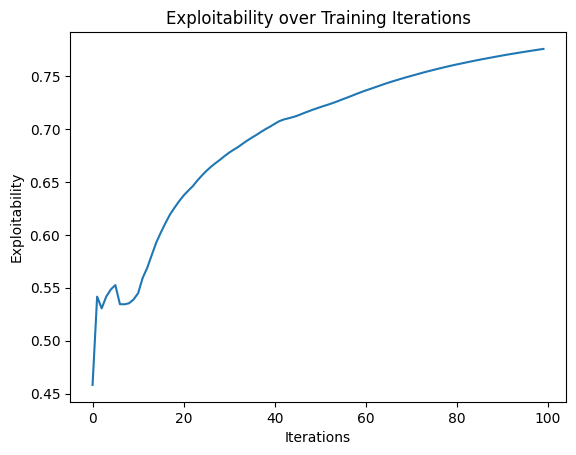

In [73]:
class TabularInfoState:
    def __init__(self, n):
        self.regret = np.zeros(n)
        self.strategy = np.zeros(n)

class UniformSampler:
    def __call__(self, infostate, n):
        return np.full(n, 1.0 / n)

class AveragePolicy(policy.Policy):
    def __init__(self, game, player_ids, cum_strategy):
        super().__init__(game, player_ids)
        self.game = game
        self.cum_strategy = cum_strategy

    def action_probabilities(self, state, player_id=None):
        if player_id is None:
            player_id = state.current_player()
        legal_actions = state.legal_actions()
        if not legal_actions:
            return {}
        info_state = state.information_state_string(player_id)
        tmp_policy = np.zeros(self.game.num_distinct_actions())
        if info_state in self.cum_strategy and self.cum_strategy[info_state].sum() > 0:
            sum = self.cum_strategy[info_state].sum()
            #print(tmp_policy)
            for i, a in enumerate(legal_actions):
                #print(f'i:{i}, a:{a}')
                #print(tmp_policy[a])
                tmp_policy[a] = self.cum_strategy[info_state][i] / sum

            #tmp_policy[legal_actions] = self.cum_strategy[info_state][legal_actions] / self.cum_strategy[info_state][legal_actions].sum()
        else:
            tmp_policy[legal_actions] = 1.0 / len(legal_actions)
        return {action: tmp_policy[action] for action in legal_actions}


class TabularESCHERSolver:
    def __init__(self, game):
        self.game = game
        self.sample_policy = UniformSampler()
        self.I = {}
        self.value = {}
        self.rng = np.random.default_rng()
        self.cum_strategies = defaultdict(lambda: np.zeros(game.num_distinct_actions()))
        self.exploitability_history = []

    def strategy(self, I):
        infostate = self.I.get(I, None)
        if infostate is None:
            L = len(self.game.legal_actions(I))
            return np.full(L, 1.0 / L)
        else:
            sigma = np.copy(infostate.strategy)
            return sigma / np.sum(sigma)

    def regret_match_strategy(self, infostate):
        pos_regret = np.maximum(infostate.regret, 0)
        sum_regret = np.sum(pos_regret)
        if sum_regret > 0:
            return pos_regret / sum_regret
        else:
            return np.full_like(pos_regret, 1.0 / len(pos_regret))

    def infostate(self, h, n):
        infokey = h.information_state_string(h.current_player())
        if infokey not in self.I:
            self.I[infokey] = TabularInfoState(n)
        return self.I[infokey]

    def train(self, T, show_progress=True):
        # 全ての状態価値を事前に計算
        self.fill_all_values(self.game.new_initial_state())
        
        for t in range(T):
            if t % 10 == 0 and show_progress:
                print(f'{t}回目')
            for p in [0, 1]:
                self.traverse(self.game.new_initial_state(), p)
            # Update cumulative strategies
            for k, v in self.I.items():
                if len(self.cum_strategies[k]) != len(v.strategy):
                    self.cum_strategies[k] = v.strategy
                else:
                    self.cum_strategies[k] += v.strategy
            # Calculate exploitability and store it
            if (t + 1) % 1 == 0:
                ave_policy = AveragePolicy(self.game, list(range(self.game.num_players())), self.cum_strategies)
                expl = exploitability.exploitability(self.game, ave_policy)
                self.exploitability_history.append(expl)

    def traverse(self, state, p):
        if state.is_terminal():
            return state.returns()[p]
        elif state.is_chance_node():
            outcomes_with_probs = state.chance_outcomes()
            action_list, prob_list = zip(*outcomes_with_probs)
            action = self.rng.choice(action_list, p=prob_list)
            state.apply_action(action)
            return self.traverse(state, p)

        infokey = state.information_state_string(state.current_player())
        legal_actions = state.legal_actions()
        I = self.infostate(state, len(legal_actions))

        if state.current_player() == p:
            pi_sample = self.sample_policy(I, len(legal_actions))
            sigma = self.regret_match_strategy(I)
            action = self.rng.choice(legal_actions, p=pi_sample)
            v = 0.0
            r_hat = np.zeros(len(sigma))
            for i, a in enumerate(legal_actions):
                state_copy = state.child(a)
                q = self.value[tuple(state_copy.history())]
                print(f'q:{q}')
                r_hat[i] = q
                v += sigma[i] * q
            r_hat -= v
            print(f'v:{v}, r_hat:{r_hat}')
            I.regret += r_hat
            I.strategy += sigma
            state.apply_action(action)
            return self.traverse(state, p)
        else:
            pi_ni = self.regret_match_strategy(I)
            action = self.rng.choice(legal_actions, p=pi_ni)
            state.apply_action(action)
            return self.traverse(state, p)

    def fill_all_values(self, state):
        if state.is_terminal():
            u = state.returns()[0]
            self.value[tuple(state.history())] = u
            return u
        elif state.is_chance_node():
            outcomes_with_probs = state.chance_outcomes()
            v = 0.0
            for action, prob in outcomes_with_probs:
                state_copy = state.child(action)
                v += prob * self.fill_all_values(state_copy)
            self.value[tuple(state.history())] = v
            return v
        else:
            infokey = state.information_state_string(state.current_player())
            sigma = self.regret_match_strategy(self.infostate(state, len(state.legal_actions())))
            v = 0.0
            for i, a in enumerate(state.legal_actions()):
                state_copy = state.child(a)
                v += sigma[i] * self.fill_all_values(state_copy)
            self.value[tuple(state.history())] = v
            return v

    def get_tabular_policy(self):
        tabular_policy = {}
        for infokey, infostate in self.I.items():
            total_strategy = np.sum(infostate.strategy)
            if total_strategy > 0:
                normalized_strategy = infostate.strategy / total_strategy
            else:
                normalized_strategy = np.full_like(infostate.strategy, 1.0 / len(infostate.strategy))
            tabular_policy[infokey] = [(i, prob) for i, prob in enumerate(normalized_strategy)]
        return pyspiel.TabularPolicy(tabular_policy)


game = pyspiel.load_game("kuhn_poker")
solver = TabularESCHERSolver(game)
solver.train(100)

plt.plot(solver.exploitability_history)
plt.xlabel('Iterations')
plt.ylabel('Exploitability')
plt.title('Exploitability over Training Iterations')
plt.show()
